In [0]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import cv2
from google.colab import drive
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

#To use in Google Colab
#drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#Reading the labels
%%time
d = Table.read('/content/gdrive/My Drive/galaxy_zoo/galaxy_zoo_labels.csv')
ID = np.asarray(d['GalaxyID'])
len(d)

CPU times: user 447 ms, sys: 20.7 ms, total: 467 ms
Wall time: 556 ms


In [0]:
#!unzip -uq '/content/gdrive/My Drive/galaxy_zoo/galaxy_zoo_images.zip'
#### FOR GOOGLE COLAB

In [0]:
#Loading images from the database
%%time
imgdata1 = []    #list to store cropped data
#file = open('/content/gdrive/My Drive/galaxy_zoo/data_120_12k_centered.txt','wb') #To store and save in a file
for i in range(10000,11000):
        
    path='/content/images_training_rev1/'
    im = cv2.imread(path+str(ID[i])+'.jpg')

    '''
    NOTE: This part of the code is to identify the brightest point as the centre from cropping but we are using image center as the crop center at the moment.
    
    
    im = Image.open('/content/images_training_rev1/{0}.jpg'.format(ID[i]))    #reading individual images from ID(filenames)
    pix = im.load()
    pix_val = im.getdata()
    pix = np.asarray(pix_val)    #pixel data in array
    n,m = np.shape(pix_val)
    
    
    RGB_sum = np.zeros(179776)    #array of R+G+B for all pixels

    for i in range(179776):
        RGB_sum[i] = sum(pix[i,:])

    centre = np.argmax(RGB_sum)    #Finding brightest point in array
   
    for i in range(centre, n):    #loop to identify 
        if RGB_sum[i] <= 40:
            temp_w = i - centre
            break
        else:
            continue
    '''
    crop_img = im[151:271, 151:271]
    #cv2.imshow('Image', crop_img)
    #cv2.waitKey(0) 
    
    imgdata1.append((crop_img)/255)
    if i % 2000 == 0:
        print(i)
    
#pickle.dump((imgdata1), file)
#file.close()

10000
CPU times: user 1.97 s, sys: 300 ms, total: 2.27 s
Wall time: 2.76 s


In [0]:
## Load saved data file
f1 = open('/content/gdrive/My Drive/galaxy_zoo/data_120_centered.txt','rb')
data1 = pickle.load(f1)
f1.close()

In [0]:
#Reshaping the data in a format that can be used for training
X = np.asarray(data1).reshape((len(data1), 120, 120, 3))

In [0]:
## Reading labels for Q1 of classification tree categories
n = len(X)
q1 = np.zeros(3*n).reshape(n,3)
for i in range(n):
    q1[i] = [d['Class1.1'][i],d['Class1.2'][i],d['Class1.3'][i]]
    
maxi = []
for i in range(n):
    maxi.append(np.argmax(q1[i,:]))

y = np.zeros(3*n).reshape(n,3)
for i in range(n):
    y[i,maxi[i]] = 1

In [0]:
## Reading labels for Q6 of classification tree categories
n = len(X)
y = np.zeros(2*n).reshape(n,2)
for i in range(n):
    if d['Class6.1'][i]>=0.5:
        y[i,0] = 1
        #y[1] = 0
        
    else:
        y[i,1] = 1

In [0]:
#Data Split
X_train, X_test, y_train, y_test = X[:9000], X[9000:], y[:9000], y[9000:]

In [0]:
#Define architecture of that will be used for CNN

def cnn_alexnet():
    cnn = tf.keras.Sequential()

    cnn.add(tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=4, padding='same', activation='relu', input_shape=(120,120,3)))
        
    cnn.add(tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same'))

    cnn.add(tf.keras.layers.Conv2D(filters=265, kernel_size=5, padding='same', activation='relu'))

    cnn.add(tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='valid'))  

    cnn.add(tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same', activation='relu'))

    cnn.add(tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same', activation='relu'))

    cnn.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))

    cnn.add(tf.keras.layers.MaxPooling2D(pool_size=3, strides=2))  



    cnn.add(tf.keras.layers.Flatten())
    shape=cnn.output_shape[1]
    print(shape)
    cnn.add(tf.keras.layers.Dense(shape, activation='relu'))
    cnn.add(tf.keras.layers.Dense(1024, activation='relu'))   
    cnn.add(tf.keras.layers.Dense(512, activation='relu'))    
    cnn.add(tf.keras.layers.Dense(3, activation='softmax'))
    
    return cnn

In [0]:
#Define architecture of that will be used for CNN

def cnn_lenet():
    cnn2 = tf.keras.models.Sequential()

    cnn2.add(tf.keras.layers.Conv2D(6, kernel_size=5, padding='same', activation='relu', input_shape=(120,120,3)))
    cnn2.add(tf.keras.layers.AveragePooling2D(pool_size=2, strides=2, padding='valid'))
    cnn2.add(tf.keras.layers.Activation('relu'))

    cnn2.add(tf.keras.layers.Conv2D(16, kernel_size=5, activation='relu', padding='valid'))
    cnn2.add(tf.keras.layers.AveragePooling2D(pool_size=2, strides=2, padding='valid'))
    cnn2.add(tf.keras.layers.Activation('relu'))

    cnn2.add(tf.keras.layers.Flatten())

    cnn2.add(tf.keras.layers.Dense(units=120, activation='relu'))
    cnn2.add(tf.keras.layers.Dense(units=84, activation='relu'))
    cnn2.add(tf.keras.layers.Dense(units=3, activation = 'softmax'))
    return cnn2

In [0]:
#Define architecture of that will be used for CNN

def cnn_new():
    cnn = tf.keras.Sequential()
    cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=4, padding='same', activation='relu', input_shape=(120,120,3)))
    cnn.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
    cnn.add(tf.keras.layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0))
            
    cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=4, padding='same', activation='relu'))
    cnn.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
    cnn.add(tf.keras.layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0))
    #cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=4, padding='same', activation='relu'))
    cnn.add(tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same'))
            
    cnn.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=4, padding='same', activation='relu'))
    cnn.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
    cnn.add(tf.keras.layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0))
            
    cnn.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=4, padding='same', activation='relu'))
    cnn.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
    cnn.add(tf.keras.layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0))
    #cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=4, padding='same', activation='relu'))
    cnn.add(tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same'))

            
    cnn.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=4, padding='same', activation='relu'))
    cnn.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
    cnn.add(tf.keras.layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0))
            
    cnn.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=4, padding='same', activation='relu'))
    cnn.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
    cnn.add(tf.keras.layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0))
            
    cnn.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=4, padding='same', activation='relu'))
    cnn.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
    cnn.add(tf.keras.layers.ReLU(max_value=None, negative_slope=0.0, threshold=0.0))
            

    cnn.add(tf.keras.layers.Flatten())
    shape=cnn.output_shape[1]
    #print(shape)
    cnn.add(tf.keras.layers.Dense(shape, activation='relu'))
    #cnn.add(tf.keras.layers.Dense(1024, activation='relu'))   
    cnn.add(tf.keras.layers.Dense(512, activation='relu'))    
    cnn.add(tf.keras.layers.Dense(3, activation='softmax'))
    
    return cnn

In [0]:
#Define architecture of that will be used for CNN

def cnn_new2():
    cnn = tf.keras.Sequential()
    cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=10, strides=2, padding='same', activation='relu', input_shape=(120,120,3)))
    cnn.add(tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same'))
    cnn.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))

    
    cnn.add(tf.keras.layers.Conv2D(filters=128, kernel_size=5, strides=2, padding='same', activation='relu'))
    cnn.add(tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same'))
    cnn.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
    
    cnn.add(tf.keras.layers.Conv2D(filters=256, kernel_size=5, strides=2, padding='same', activation='relu'))
    cnn.add(tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='valid'))  

    #cnn.add(tf.keras.layers.Conv2D(filters=256, kernel_size=5, strides=2, padding='same', activation='relu'))

    cnn.add(tf.keras.layers.Flatten())
    shape=cnn.output_shape[1]
    #print(shape)
    cnn.add(tf.keras.layers.Dense(shape, activation='relu', activity_regularizer=tf.keras.regularizers.l1(0.0001)))
    #cnn.add(tf.keras.layers.Dense(1024, activation='relu'))   
    cnn.add(tf.keras.layers.Dense(500, activation='relu'))    
    cnn.add(tf.keras.layers.Dense(3, activation='softmax'))
    
    return cnn

In [0]:
#Define architecture of that will be used for CNN

def cnn_vgg16():

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.ZeroPadding2D((1,1),input_shape=(120,120,3)))
    model.add(tf.keras.layers.Convolution2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.Convolution2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)))

    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.Convolution2D(128, (3, 3), activation='relu'))
    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.Convolution2D(128, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)))

    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.Convolution2D(256, (3, 3), activation='relu'))
    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.Convolution2D(256, (3, 3), activation='relu'))
    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.Convolution2D(256, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)))

    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.Convolution2D(512, (3, 3), activation='relu'))
    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.Convolution2D(512, (3, 3), activation='relu'))
    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.Convolution2D(512, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)))

    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.Convolution2D(512, (3, 3), activation='relu'))
    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.Convolution2D(512, (3, 3), activation='relu'))
    model.add(tf.keras.layers.ZeroPadding2D((1,1)))
    model.add(tf.keras.layers.Convolution2D(512, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(4096, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(4096, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(3, activation='softmax'))
    
    return model


In [0]:
#Check the summary of CNN here and assign optimizer and loss functions!!
###########################
cnn = cnn_alexnet()
cnn.summary()

adamax = tf.keras.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)

#sgd = tf.keras.optimizers.SGD(lr=0.005, decay=1e-6, momentum=0.9, nesterov=True)
#cnn.compile(optimizer=adamax, loss='mean_squared_error', metrics=['accuracy', f1_score])
cnn.compile(loss='kullback_leibler_divergence', optimizer='adam', metrics=['accuracy'])

2304
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_111 (Conv2D)          (None, 30, 30, 96)        34944     
_________________________________________________________________
max_pooling2d_72 (MaxPooling (None, 15, 15, 96)        0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 15, 15, 265)       636265    
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 7, 7, 265)         0         
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 7, 7, 384)         916224    
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 7, 7, 384)         1327488   
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 7, 7, 256)         884992    
_____

In [0]:
# Train your model
################

#history = cnn.fit(X_train, y_train, epochs=, batch_size=128, verbose=1)
history_lenet = cnn.fit(X, y, validation_split=0.15, epochs=20, batch_size=128, verbose=1)

Train on 8500 samples, validate on 1500 samples
Epoch 1/20
8500/8500 [==============================] - 12s 1ms/sample - loss: 6.9047 - acc: 0.5575 - val_loss: 6.9738 - val_acc: 0.5673
Epoch 2/20
8500/8500 [==============================] - 10s 1ms/sample - loss: 7.1014 - acc: 0.5594 - val_loss: 6.9738 - val_acc: 0.5673
Epoch 3/20
8500/8500 [==============================] - 10s 1ms/sample - loss: 7.1014 - acc: 0.5594 - val_loss: 6.9738 - val_acc: 0.5673
Epoch 4/20
8500/8500 [==============================] - 10s 1ms/sample - loss: 7.1014 - acc: 0.5594 - val_loss: 6.9738 - val_acc: 0.5673
Epoch 5/20
8500/8500 [==============================] - 10s 1ms/sample - loss: 7.1014 - acc: 0.5594 - val_loss: 6.9738 - val_acc: 0.5673
Epoch 6/20
8500/8500 [==============================] - 10s 1ms/sample - loss: 7.1014 - acc: 0.5594 - val_loss: 6.9738 - val_acc: 0.5673
Epoch 7/20
8500/8500 [==============================] - 10s 1ms/sample - loss: 7.1014 - acc: 0.5594 - val_loss: 6.9738 - val_acc: 

In [0]:
# Evaluate your results

score = cnn.evaluate(X_test, y_test, verbose=1)
score[1]

4000/4000 [==============================] - 3s 719us/sample - loss: 1.1519 - acc: 0.7247 - f1_score: 0.7247


0.72475

In [0]:
### Save your results
#cnn.save('cnn_test.h5')
#load cnn model
cnn1.save('Lenet_8.5k_20Epocs_SGD(0.01)_cnn_test.h5')

dict_keys(['loss', 'acc', 'f1_score', 'val_loss', 'val_acc', 'val_f1_score'])


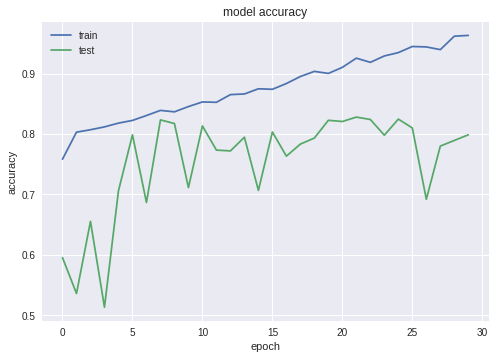

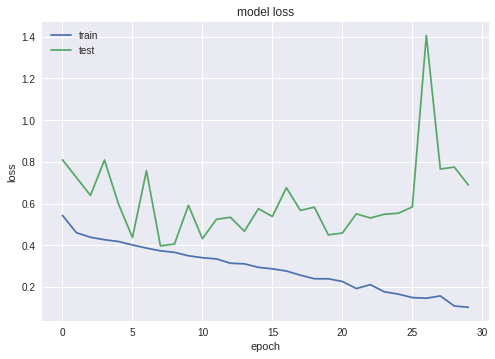

In [0]:
#Plot learning curves
##########

history = history_lenet
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
y_pred_test = cnn.predict_proba(X_test)

(4000, 3)

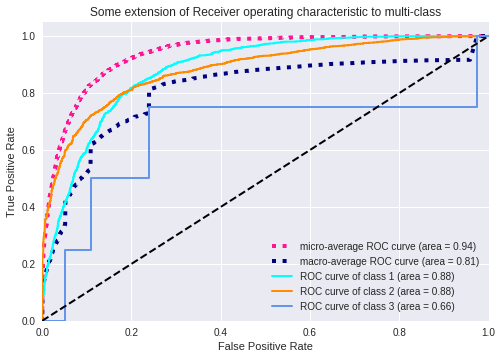

In [0]:
####################
#Plot ROC
####################


# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
n_classes = 3
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], th = roc_curve(y_test[:, i], y_pred_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred_test.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))


# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [0]:
#Introduing the Metric F1 Score
#######################
def f1_score(y_true, y_pred):
    y_true = tf.cast(y_true, "int32")
    y_pred = tf.cast(tf.round(y_pred), "int32") # implicit 0.5 threshold via tf.round
    y_correct = y_true * y_pred
    sum_true = tf.reduce_sum(y_true, axis=1)
    sum_pred = tf.reduce_sum(y_pred, axis=1)
    sum_correct = tf.reduce_sum(y_correct, axis=1)
    precision = sum_correct / sum_pred
    recall = sum_correct / sum_true
    f_score = 2* precision * recall / (precision + recall)
    f_score = tf.where(tf.is_nan(f_score), tf.zeros_like(f_score), f_score)
    return tf.reduce_mean(f_score)

In [0]:
## Model Summary but now we included F1 Score as a metric as well

cnn = cnn_vgg16()
cnn.summary()

sgd = tf.keras.optimizers.SGD(lr=0.005, decay=1e-6, momentum=0.9, nesterov=True)
cnn.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy', f1_score])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 122, 122, 3)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 120, 120, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 122, 122, 64)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 120, 120, 64)      36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 60, 60, 64)        0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 62, 62, 64)        0         
___________________________

In [0]:
history_lenet = cnn.fit(X, y, validation_split=0.15, epochs=30, batch_size=128, verbose=1)

Train on 8500 samples, validate on 1500 samples
Epoch 1/30
8500/8500 [==============================] - 95s 11ms/sample - loss: 0.8540 - acc: 0.5558 - f1_score: 0.2718 - val_loss: 0.6946 - val_acc: 0.5673 - val_f1_score: 0.5665
Epoch 2/30
8500/8500 [==============================] - 80s 9ms/sample - loss: 0.6967 - acc: 0.5491 - f1_score: 0.5436 - val_loss: 0.7066 - val_acc: 0.4320 - val_f1_score: 0.4318
Epoch 3/30
8500/8500 [==============================] - 80s 9ms/sample - loss: 0.6959 - acc: 0.5468 - f1_score: 0.5398 - val_loss: 0.6870 - val_acc: 0.5673 - val_f1_score: 0.5668
Epoch 4/30
8500/8500 [==============================] - 80s 9ms/sample - loss: 0.6875 - acc: 0.5680 - f1_score: 0.5644 - val_loss: 0.6721 - val_acc: 0.5673 - val_f1_score: 0.5665
Epoch 5/30
8500/8500 [==============================] - 80s 9ms/sample - loss: 0.6685 - acc: 0.6129 - f1_score: 0.6080 - val_loss: 0.6251 - val_acc: 0.6933 - val_f1_score: 0.6902
Epoch 6/30
8500/8500 [==============================] - 

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


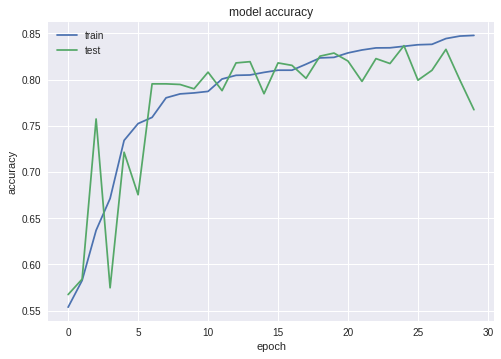

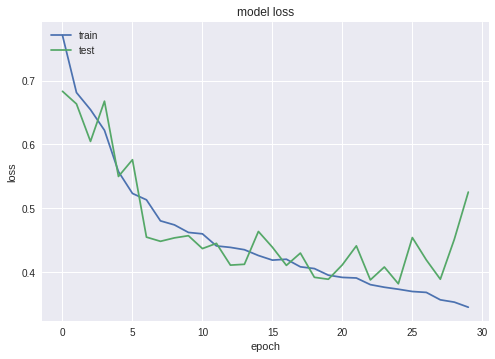

In [0]:
history = history_lenet
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()